#**CHAPTER 6. VOLATILITY TRADING**
---

##0.REFERENCE

##1.CONTEXT

**Introduction**

This notebook belongs to the series *Mechanism-First Financial Systems — Agentic Trading Laboratories*, a collection designed to expose the structural foundations of financial markets through controlled, synthetic experimentation. The objective of this particular laboratory is to study the economic logic embedded in implied volatility markets and to demonstrate how volatility surfaces arise, evolve, and interact with trading behavior under realistic execution constraints. The notebook is not a forecasting tool, nor a strategy blueprint. It is a mechanism laboratory whose purpose is to make causal structure visible, testable, and falsifiable.

Volatility occupies a distinct position in modern financial markets. Unlike prices, which are directly observable and transacted, volatility is an inferred quantity, extracted from option prices and shaped by expectations, risk aversion, supply–demand imbalances, and institutional constraints. The implied volatility surface—organized across option maturity and moneyness—summarizes how the market prices uncertainty across time horizons and payoff asymmetries. Understanding this surface is therefore essential for interpreting risk premia, tail compensation, and regime sensitivity in derivative markets.

The economic compensation embedded in volatility markets is often described in terms of variance risk premia. In tranquil conditions, option sellers are typically compensated for bearing volatility risk, earning carry through the systematic sale of convexity. This compensation is not arbitrary. It reflects the willingness of end users to pay for insurance, the balance-sheet costs borne by dealers, and the structural demand for protection by leveraged portfolios. However, this same compensation is fragile. It is punctuated by abrupt repricing during regime transitions, volatility clustering, and jump events. The volatility surface is the primary object through which this repricing is expressed.

This notebook focuses on implied volatility as a tradable surface rather than as an abstract statistic. By constructing a synthetic volatility tensor indexed by maturity and moneyness, the notebook makes explicit the object on which trading decisions are formed. Calendar relationships, skew differentials, and level shifts are not treated as secondary indicators but as first-class economic signals. The surface exists because the market prices different forms of uncertainty differently, and those prices move as regimes change.

A central motivation for a mechanism-first approach is to avoid conflating outcomes with causes. In volatility trading, realized profits or losses are often mistakenly attributed to forecasting skill, when in reality they are driven by structural exposure to carry, convexity, and liquidity. This laboratory deliberately removes predictive ambition and replaces it with structural clarity. Prices, volatility levels, and regimes evolve according to explicit stochastic rules. There is no hidden alpha. Every outcome can be traced back to a modeled mechanism.

The notebook demonstrates how volatility surfaces respond to regime-dependent dynamics such as changes in volatility of volatility, jump intensity, and correlation structure. Calm regimes are characterized by stable surfaces and predictable carry behavior. Transition regimes introduce surface deformation, particularly in skew and term structure. Stress regimes amplify convexity and liquidity effects, leading to nonlinear losses for positions that previously appeared stable. These dynamics are not imposed ex post; they emerge from the interaction between the synthetic market process and the execution environment.

Agentic structure is a defining feature of this laboratory. Trading decisions are generated by bounded policies operating within a constrained action space. At each time step, the agent selects among predefined surface expressions—remaining flat, taking short volatility exposure, taking long volatility exposure, or engaging in calendar trades. The agent cannot invent new instruments, modify parameters, or bypass constraints. This restriction is deliberate. It mirrors the reality faced by professional traders, whose degrees of freedom are limited by mandates, risk limits, and market microstructure.

Two classes of policies are supported. A deterministic rule-based policy provides a transparent baseline that reacts mechanically to surface features and regime indicators. An optional language-model-driven policy operates under the same constraints, selecting actions based on compact summaries of state and surface information. Crucially, the agent’s role is not to optimize in an unconstrained sense but to navigate trade-offs imposed by execution costs, leverage limits, and drawdown controls. Intelligence, in this context, is the ability to allocate exposure across surface dimensions while respecting these constraints.

Execution realism is a core component of the design. Trades incur proportional costs, slippage, and impact proxies that depend on regime-specific liquidity conditions. Leverage is capped, positions are bounded, and drawdown stops are enforced. These features ensure that theoretical surface relationships are filtered through the frictions that dominate real-world outcomes. In volatility markets, execution often overwhelms signal quality, particularly during regime shifts. The notebook is constructed to make this dominance visible rather than abstract.

By running a closed-loop backtest, the laboratory illustrates how repeated interactions between the agent and the market accumulate into equity trajectories, cost profiles, and drawdowns. Diagnostics are not limited to an equity curve. The notebook produces regime plots, cost accumulation paths, action frequency counts, and interpretive tables that connect observed behavior to underlying mechanisms. Each diagnostic is intended to answer a structural question: where does carry come from, when does it disappear, and why does execution determine survival.

Throughout the notebook, the emphasis remains on mechanism-first thinking. Surfaces are not treated as signals to be optimized but as economic objects to be interpreted. Regimes are not labels to be predicted but states that alter the payoff structure of exposure. Agents are not black boxes but constrained decision-makers embedded in an environment that penalizes overreach. By isolating these elements in a synthetic setting, the notebook provides a controlled space for developing professional intuition about volatility markets.

This laboratory is therefore best understood as an educational instrument. It is designed for practitioners and researchers who wish to interrogate the structure of volatility markets without the confounding influence of historical data idiosyncrasies or backtest overfitting. By making every assumption explicit and every mechanism traceable, the notebook invites systematic experimentation. Parameters can be varied, regimes altered, and policies compared, all while preserving the integrity of the underlying economic logic.

In summary, this notebook demonstrates how implied volatility surfaces emerge from economic compensation for risk, how they deform under regime shifts, and how execution constraints convert theoretical exposure into realized fragility. It does so without prediction, without performance claims, and without recourse to hidden complexity. The goal is not to discover strategies, but to understand structure.


##2.LIBRARIES AND ENVIRONMENT

In [9]:
# Install (Colab-safe). Keep minimal deps; OpenAI SDK only if LLM policy enabled.
import sys, subprocess, os, json, math, time, hashlib
def _pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Repro + config (single source of truth)
run_config = {
    "chapter_id": 6,
    "chapter_name": "Volatility Surface — Implied Vol Economics",
    "seed": 7,
    "T": 800,
    "dt": 1.0,

    "regimes": {
        "names": ["calm", "transition", "stress"],
        # mild persistence; stress is sticky but not absorbing
        "markov_P": [
            [0.965, 0.030, 0.005],
            [0.080, 0.860, 0.060],
            [0.020, 0.120, 0.860],
        ],
        "notes": "Regime drives vol-of-vol, jump intensity, skew pressure, and illiquidity."
    },

    "market_params": {
        "mechanism": "variance risk premium (carry) vs convexity losses under regime-dependent vol dynamics",
        "spot0": 100.0,
        "mu": 0.00,                 # drift not the point
        "base_vol": 0.15,
        "vol_floor": 0.06,
        "vol_cap": 0.90,
        "vol_of_vol": {"calm": 0.08, "transition": 0.18, "stress": 0.40},
        "jump_intensity": {"calm": 0.004, "transition": 0.012, "stress": 0.035},   # per step
        "jump_scale": {"calm": 0.012, "transition": 0.028, "stress": 0.060},       # spot jump magnitude
        "skew_pressure": {"calm": 0.35, "transition": 0.60, "stress": 0.95},       # increases put skew
        "mean_revert_kappa": 0.10,   # vol mean reversion speed toward base_vol
    },

    "surface_params": {
        "surface_type": "tensor",
        "axes": {
            "tenor_days": [7, 30, 90, 180],
            "moneyness": [-0.10, -0.05, 0.00, 0.05, 0.10],
        },
        "construction": "implied vol = f(vol_level, term_structure, smile, skew, regime skew pressure)",
        "term_structure_slope": {"calm": -0.02, "transition": 0.00, "stress": 0.06},  # long > short in stress
        "smile_curvature": {"calm": 0.50, "transition": 0.65, "stress": 0.90},
    },

    "execution_params": {
        "cost_fixed": 0.0,
        "cost_bps": 2.0,            # proportional to notional proxy
        "slippage_lambda": 0.15,    # impact coefficient
        "impact_proxy": "abs(trade_size) * slippage_lambda * illiquidity_t",
        "illiquidity_by_regime": {"calm": 0.6, "transition": 1.2, "stress": 2.8},
    },

    "risk_params": {
        "initial_equity": 1_000_000.0,
        "max_leverage": 2.0,
        "pos_limit_vega": 1.0,       # absolute cap for each exposure component
        "trade_rate_limit": 0.25,    # max change per step (prevents unrealistic re-hedging)
        "max_dd_stop": 0.20
    },

    "strategy_params": {
        # "carry" paid/earned per step per unit of net short/long vega (stylized variance risk premium)
        "theta_carry_calm": 220.0,
        "theta_carry_transition": 120.0,
        "theta_carry_stress": 40.0,     # carry compresses in stress; spreads widen
        # sensitivity of PnL to surface repricing (vega-like)
        "vega_pnl_scale": 8500.0,
        # convexity penalty for short vol under large spot moves (dominates in stress)
        "convexity_coeff": 9000.0,
        "tail_threshold": 0.018,        # threshold in |dS/S| before convexity really bites
        # calendar: long long-dated vol, short short-dated vol (net vega ~0, term-structure bet)
        "calendar_sensitivity": 6000.0,
    },

    "policy_params": {
        "enable_llm": True,
        "llm_model": "gpt-4o-mini",
        "llm_temperature": 0.0,
        "fallback_to_baseline_on_error": True,
        "max_rationale_chars": 260
    }
}

# Deterministic identity hash (audit)
def stable_hash(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()[:16]

payload_hash = stable_hash(json.dumps(run_config, sort_keys=True))
print("run_config payload_hash:", payload_hash)
print(json.dumps(run_config, indent=2))

# RNG
SEED = int(run_config["seed"])
rng = np.random.default_rng(SEED)

# Lightweight logging container
LOG_FIELDS = [
    "t","regime_id","regime","spot","vol_level","vov","skew","jump_proxy",
    "surface_atm_30d","surface_put_30d","surface_call_30d","term_slope",
    "action","rationale",
    "pos_outright","pos_calendar","trade_outright","trade_calendar",
    "gross_exposure","leverage","cost","impact","pnl_step","pnl_carry","pnl_vega","pnl_convexity",
    "equity","drawdown"
]

def dd_from_equity(eq: np.ndarray) -> np.ndarray:
    peak = np.maximum.accumulate(eq)
    return 1.0 - (eq / np.maximum(1e-12, peak))


run_config payload_hash: 2080198231de3e37
{
  "chapter_id": 6,
  "chapter_name": "Volatility Surface \u2014 Implied Vol Economics",
  "seed": 7,
  "T": 800,
  "dt": 1.0,
  "regimes": {
    "names": [
      "calm",
      "transition",
      "stress"
    ],
    "markov_P": [
      [
        0.965,
        0.03,
        0.005
      ],
      [
        0.08,
        0.86,
        0.06
      ],
      [
        0.02,
        0.12,
        0.86
      ]
    ],
    "notes": "Regime drives vol-of-vol, jump intensity, skew pressure, and illiquidity."
  },
  "market_params": {
    "mechanism": "variance risk premium (carry) vs convexity losses under regime-dependent vol dynamics",
    "spot0": 100.0,
    "mu": 0.0,
    "base_vol": 0.15,
    "vol_floor": 0.06,
    "vol_cap": 0.9,
    "vol_of_vol": {
      "calm": 0.08,
      "transition": 0.18,
      "stress": 0.4
    },
    "jump_intensity": {
      "calm": 0.004,
      "transition": 0.012,
      "stress": 0.035
    },
    "jump_scale": {
      "ca

##3.REGIME PROCESS

###3.1.OVERVIEW

**Cell 3 — Regime Process and State Evolution**

Cell 3 establishes the structural backbone of the laboratory by defining the regime process and the core state variables that govern market behavior over time. Its purpose is to make explicit the idea that financial markets do not evolve under a single, stationary law. Instead, they transition between regimes that alter the payoff structure of exposure. In the context of implied volatility markets, these regimes capture differences in stability, uncertainty propagation, and tail sensitivity.

The cell models regimes as a discrete-time Markov process. This choice is deliberate. The Markov structure forces regime persistence and transition probabilities to be explicit parameters rather than latent assumptions. Calm regimes are characterized by stable volatility levels and low volatility of volatility. Transition regimes introduce instability in surface shape and heightened sensitivity to shocks. Stress regimes amplify convexity, jump risk, and liquidity deterioration. These regimes are not forecasts; they are structural states that condition how the rest of the system behaves.

Alongside the regime process, Cell 3 defines the evolution of fundamental state variables such as spot price, baseline volatility, volatility of volatility, and jump proxies. Each variable is linked to the current regime, ensuring that regime shifts have concrete, measurable consequences. For example, volatility clustering arises naturally because the volatility process itself becomes more unstable in certain regimes. Jump risk activates discontinuities that cannot be hedged smoothly through incremental trading.

The learning objective of this cell is to anchor all subsequent dynamics in a small, interpretable state vector. Rather than allowing complexity to emerge implicitly, the notebook forces the reader to confront which variables matter and why. This reinforces a key mechanism-first principle: before discussing strategies or agents, one must specify the economic environment that generates risk and compensation.

By isolating regime dynamics early, Cell 3 ensures that later observations—such as sudden drawdowns or surface distortions—can be traced back to structural causes. This cell does not produce tradable objects or decisions, but it defines the causal context in which all trading occurs. Without it, later behavior would appear arbitrary. With it, outcomes become explainable in economic terms.


###3.2.CODE AND IMPLEMENTATION

In [10]:
# Regime process + explicit state evolution
reg_names = run_config["regimes"]["names"]
P = np.array(run_config["regimes"]["markov_P"], dtype=float)
assert P.shape == (3,3) and np.allclose(P.sum(axis=1), 1.0)

T = int(run_config["T"])
dt = float(run_config["dt"])

# Regime simulation
regime_id = np.zeros(T, dtype=int)
regime_id[0] = 0  # start calm by construction
for t in range(1, T):
    regime_id[t] = rng.choice(3, p=P[regime_id[t-1]])

regime = np.array([reg_names[i] for i in regime_id], dtype=object)

mp = run_config["market_params"]

spot = np.zeros(T, dtype=float)
vol_level = np.zeros(T, dtype=float)
vov = np.zeros(T, dtype=float)
skew = np.zeros(T, dtype=float)        # higher => more negative put skew pressure
jump_proxy = np.zeros(T, dtype=float)  # realized jump magnitude indicator

spot[0] = mp["spot0"]
vol_level[0] = mp["base_vol"]
vov[0] = mp["vol_of_vol"][regime[0]]
skew[0] = mp["skew_pressure"][regime[0]]
jump_proxy[0] = 0.0

kappa = mp["mean_revert_kappa"]
base_vol = mp["base_vol"]

for t in range(1, T):
    reg = regime[t]
    # Regime-driven parameters
    vov_t = mp["vol_of_vol"][reg]
    lam_j = mp["jump_intensity"][reg]
    jump_scale = mp["jump_scale"][reg]
    skew_t = mp["skew_pressure"][reg]

    # Spot innovation with stochastic vol (vol_level[t-1]) + jump component
    z = rng.standard_normal()
    dW = math.sqrt(dt) * z
    jump = 0.0
    if rng.random() < lam_j * dt:
        # symmetric heavy-ish jump; magnitude depends on regime
        jump = jump_scale * rng.standard_normal()
    jump_proxy[t] = abs(jump)

    # Spot update (log-normal-ish; drift suppressed)
    ret = (-0.5 * vol_level[t-1]**2) * dt + vol_level[t-1] * dW + jump
    spot[t] = spot[t-1] * math.exp(ret)

    # Vol level: mean reversion + vol-of-vol shock + jump-to-vol channel
    zv = rng.standard_normal()
    dV = vov_t * 0.30 * math.sqrt(dt) * zv + 0.55 * jump_proxy[t]  # jump raises implied vol
    vol_mr = kappa * (base_vol - vol_level[t-1]) * dt
    vol_level[t] = np.clip(vol_level[t-1] + vol_mr + dV, mp["vol_floor"], mp["vol_cap"])

    # Carry state variables
    vov[t] = vov_t
    skew[t] = skew_t

# Quick sanity printout (not a plot yet)
print("Regime counts:", dict(zip(reg_names, np.bincount(regime_id, minlength=3))))
print("Spot range:", float(spot.min()), "→", float(spot.max()))
print("Vol level range:", float(vol_level.min()), "→", float(vol_level.max()))


Regime counts: {'calm': np.int64(593), 'transition': np.int64(122), 'stress': np.int64(85)}
Spot range: 0.0013602398953088042 → 1240.7529953826215
Vol level range: 0.06 → 0.7133054338931109


##4.MARKET SIMULATOR

###4.1.OVERVIEW

**Cell 3 — Regime Process and State Evolution**

Cell 3 establishes the structural backbone of the laboratory by defining the regime process and the core state variables that govern market behavior over time. Its purpose is to make explicit the idea that financial markets do not evolve under a single, stationary law. Instead, they transition between regimes that alter the payoff structure of exposure. In the context of implied volatility markets, these regimes capture differences in stability, uncertainty propagation, and tail sensitivity.

The cell models regimes as a discrete-time Markov process. This choice is deliberate. The Markov structure forces regime persistence and transition probabilities to be explicit parameters rather than latent assumptions. Calm regimes are characterized by stable volatility levels and low volatility of volatility. Transition regimes introduce instability in surface shape and heightened sensitivity to shocks. Stress regimes amplify convexity, jump risk, and liquidity deterioration. These regimes are not forecasts; they are structural states that condition how the rest of the system behaves.

Alongside the regime process, Cell 3 defines the evolution of fundamental state variables such as spot price, baseline volatility, volatility of volatility, and jump proxies. Each variable is linked to the current regime, ensuring that regime shifts have concrete, measurable consequences. For example, volatility clustering arises naturally because the volatility process itself becomes more unstable in certain regimes. Jump risk activates discontinuities that cannot be hedged smoothly through incremental trading.

The learning objective of this cell is to anchor all subsequent dynamics in a small, interpretable state vector. Rather than allowing complexity to emerge implicitly, the notebook forces the reader to confront which variables matter and why. This reinforces a key mechanism-first principle: before discussing strategies or agents, one must specify the economic environment that generates risk and compensation.

By isolating regime dynamics early, Cell 3 ensures that later observations—such as sudden drawdowns or surface distortions—can be traced back to structural causes. This cell does not produce tradable objects or decisions, but it defines the causal context in which all trading occurs. Without it, later behavior would appear arbitrary. With it, outcomes become explainable in economic terms.


###4.2.CODE AND IMPLEMENTATION

In [11]:
# Market simulator: build a tradable implied vol tensor each t (tenor × moneyness)
sp = run_config["surface_params"]
tenors = np.array(sp["axes"]["tenor_days"], dtype=float)
mny = np.array(sp["axes"]["moneyness"], dtype=float)  # negative = put wing; positive = call wing

def build_surface(vol_t: float, reg: str, skew_pressure: float) -> np.ndarray:
    """
    Returns tensor iv[tenor_idx, mny_idx].
    Construction: base vol level * term structure + smile curvature + skew tilt.
    """
    term_slope = sp["term_structure_slope"][reg]
    smile_curv = sp["smile_curvature"][reg]

    # Normalize tenor to [0,1] for smooth shaping
    tau = (tenors - tenors.min()) / max(1e-12, (tenors.max() - tenors.min()))

    # Term structure factor (stress => longer-dated vol higher)
    term_factor = 1.0 + term_slope * (tau - tau.mean())

    # Smile + skew: smile is quadratic in moneyness; skew is linear and stronger on puts
    # Put wing gets extra skew-pressure; call wing gets less.
    smile = 1.0 + smile_curv * (mny**2)

    # Skew tilt: negative moneyness increases implied vol; positive slightly decreases
    tilt = 1.0 + (0.55 * skew_pressure) * (-mny) + (0.10 * skew_pressure) * (-np.clip(mny, 0, None))

    iv = vol_t * np.outer(term_factor, smile * tilt)
    return np.clip(iv, 0.01, 2.00)

# Build surfaces over time
surfaces = np.zeros((T, len(tenors), len(mny)), dtype=float)
term_slope_series = np.zeros(T, dtype=float)

for t in range(T):
    reg = regime[t]
    surfaces[t] = build_surface(vol_level[t], reg, skew[t])
    term_slope_series[t] = float(sp["term_structure_slope"][reg])

# Surface summary series for agent/policy (30d ATM, 30d put wing, 30d call wing)
tenor_30_idx = int(np.argmin(np.abs(tenors - 30.0)))
mny_atm_idx = int(np.argmin(np.abs(mny - 0.0)))
mny_put_idx = int(np.argmin(np.abs(mny - (-0.05))))
mny_call_idx = int(np.argmin(np.abs(mny - (0.05))))

iv_atm_30 = surfaces[:, tenor_30_idx, mny_atm_idx]
iv_put_30 = surfaces[:, tenor_30_idx, mny_put_idx]
iv_call_30 = surfaces[:, tenor_30_idx, mny_call_idx]

print("Example surface snapshot (t=0) shape:", surfaces[0].shape)
print("ATM 30d IV mean:", float(iv_atm_30.mean()), "put wing - call wing (skew proxy) mean:",
      float((iv_put_30 - iv_call_30).mean()))


Example surface snapshot (t=0) shape: (4, 5)
ATM 30d IV mean: 0.17119563808492969 put wing - call wing (skew proxy) mean: 0.004913175804053967


##5.PORTFOLIO ENVIRONMENT

###5.1.OVERVIEW

**Cell 5 — Execution and Portfolio Environment**

Cell 5 introduces realism by embedding the tradable surface within a portfolio and execution environment. Its purpose is to ensure that economic exposure is filtered through constraints and frictions that dominate real-world outcomes. This cell formalizes positions, leverage, costs, and drawdown controls.

The portfolio is defined over a small set of interpretable exposures, corresponding to surface expressions rather than individual option contracts. Positions are bounded and leverage is capped, reflecting institutional constraints. These limits are not arbitrary. They enforce the idea that risk-taking capacity is finite and that exposure must be scaled relative to equity.

Execution costs are modeled through proportional transaction costs and regime-dependent impact proxies. Liquidity deteriorates in stress regimes, increasing the cost of adjusting positions precisely when adjustment is most urgent. This feature is critical for understanding volatility trading. Many theoretical hedges fail not because they are conceptually wrong, but because they are infeasible to execute under stress.

Drawdown controls introduce a survival constraint. Once losses exceed a predefined threshold, the system forces de-risking. This mirrors real-world risk management practices and highlights a structural asymmetry: optimization is conditional on survival. Strategies that appear optimal in expectation can be rendered irrelevant by interim losses.

The learning objective of Cell 5 is to demonstrate that execution is not an afterthought. It is an active mechanism that reshapes payoff distributions. By formalizing costs and constraints early, the notebook ensures that subsequent policy behavior cannot ignore them. This cell anchors the laboratory in professional reality, where execution often overwhelms signal quality.


###5.2.CODE AND IMPLEMENTATION

In [13]:
# FIX (Cell 5): remove the stray identifier that caused the NameError.
# Your error is triggered by a dangling token "AX" at the end of the cell.
# Delete it. Nothing else is required.

# --- CLEAN CELL 5 (drop-in replacement) ---

# Execution + portfolio environment (positions, leverage, costs, PnL, constraints)

rp = run_config["risk_params"]
ep = run_config["execution_params"]
stp = run_config["strategy_params"]

ACTIONS = ["FLAT", "LONG_VOL", "SHORT_VOL", "CALENDAR_VOL"]

# Position vector: [outright_vega, calendar_vega]
# - outright_vega drives exposure to broad IV repricing and carry
# - calendar_vega drives exposure to term structure changes (long long-dated vs short short-dated)
pos = np.zeros(2, dtype=float)

equity0 = float(rp["initial_equity"])
equity = equity0
peak_equity = equity0
stopped = False

def gross_exposure_from_pos(pos_vec: np.ndarray) -> float:
    # Exposure proxy (dimensionless): treat each unit as 1x notional slice
    return float(np.sum(np.abs(pos_vec)))

def leverage_from_pos(pos_vec: np.ndarray, eq: float) -> float:
    # Leverage proxy: gross exposure scaled to equity in millions (keeps numbers stable)
    # This is a *laboratory* leverage metric—explicit and auditable, not a broker model.
    return gross_exposure_from_pos(pos_vec) / max(1e-12, (eq / 1_000_000.0))

def execution_cost(trade_vec: np.ndarray, illiq: float) -> tuple[float, float]:
    """
    cost = proportional bps on notional proxy + impact proxy
    notional proxy = sum(abs(trade))
    """
    notional = float(np.sum(np.abs(trade_vec)))
    cost_prop = (ep["cost_bps"] * 1e-4) * notional * equity0  # scale to initial equity for interpretability
    impact = float(notional * ep["slippage_lambda"] * illiq * equity0 * 1e-6)  # softer scaling than bps
    return (ep["cost_fixed"] + cost_prop + impact), impact

def step_pnl(pos_prev: np.ndarray, t: int) -> tuple[float, dict]:
    """
    Compute PnL components given previous positions and market move from t-1 -> t.
    """
    reg = regime[t]
    # Surface repricing proxy: ΔIV at key points
    d_iv_atm = float(iv_atm_30[t] - iv_atm_30[t-1])
    d_term_slope = float(term_slope_series[t] - term_slope_series[t-1])

    # Carry (theta / VRP): short vol earns; long vol pays. Carry compresses in stress.
    if reg == "calm":
        carry_rate = stp["theta_carry_calm"]
    elif reg == "transition":
        carry_rate = stp["theta_carry_transition"]
    else:
        carry_rate = stp["theta_carry_stress"]

    outright = float(pos_prev[0])
    cal = float(pos_prev[1])

    pnl_carry = (-outright) * carry_rate  # short vol (outright<0) => positive carry

    # Vega-like repricing PnL (broad IV move)
    pnl_vega = outright * stp["vega_pnl_scale"] * d_iv_atm

    # Calendar PnL from term-structure steepening/flattening
    pnl_calendar = cal * stp["calendar_sensitivity"] * d_term_slope

    # Convexity loss for short vol when spot move is large (tail)
    dS = float((spot[t] / spot[t-1]) - 1.0)
    tail = max(0.0, abs(dS) - stp["tail_threshold"])
    pnl_convexity = 0.0
    if outright < 0:
        pnl_convexity = -stp["convexity_coeff"] * (tail**2) * abs(outright)

    pnl_step = pnl_carry + pnl_vega + pnl_calendar + pnl_convexity

    comp = {
        "pnl_carry": pnl_carry,
        "pnl_vega": pnl_vega + pnl_calendar,
        "pnl_convexity": pnl_convexity
    }
    return pnl_step, comp

def apply_constraints(pos_target: np.ndarray, eq: float) -> np.ndarray:
    # Position bounds
    lim = float(rp["pos_limit_vega"])
    pos_bounded = np.clip(pos_target, -lim, lim)

    # Leverage cap: if exceeds, scale down proportionally
    lev = leverage_from_pos(pos_bounded, eq)
    if lev > rp["max_leverage"]:
        scale = rp["max_leverage"] / max(1e-12, lev)
        pos_bounded = pos_bounded * scale
    return pos_bounded


##6.ACTION SPACE

###6.1.OVERVIEW

**Cell 6 — Action Space and Action-to-Trade Mapping**

Cell 6 defines the agent’s degrees of freedom. Its purpose is to make explicit what the agent can and cannot do, and to tie each action to a clear economic interpretation. This cell enforces bounded rationality through a finite action space.

The action set consists of a small number of surface expressions: remaining flat, taking short volatility exposure, taking long volatility exposure, and engaging in calendar volatility trades. Each action maps deterministically to portfolio targets. There is no continuous optimization or parameter tuning. This restriction reflects the reality that traders operate within predefined instruments and mandates.

The mapping from action to trade specifies how positions change given current holdings and equity. This mapping is where economic intent becomes mechanical execution. For example, a short volatility action increases exposure to variance risk premia while increasing convexity exposure. A calendar action redistributes exposure across maturities, altering sensitivity to regime transitions.

By making this mapping explicit, the notebook avoids ambiguity about what an action means. There is no hidden interpretation layer. The reader can trace how a high-level decision translates into concrete exposure and, through Cell 5, into leverage and cost consequences.

The learning objective is to reinforce discipline in action design. A well-defined action space makes policy behavior interpretable and auditable. It also prevents spurious intelligence from arising through parameter manipulation. Cell 6 ensures that any observed performance differences across policies can be attributed to decision logic rather than hidden degrees of freedom.


###6.2.CODE AND IMPLEMENTATION

In [14]:
# Action space + action→trade mapping (the only allowed actions)

trade_rate = float(rp["trade_rate_limit"])

ACTION_TO_TARGET = {
    "FLAT": np.array([0.0, 0.0], dtype=float),
    # LONG_VOL: long outright vega; no calendar
    "LONG_VOL": np.array([+1.0, 0.0], dtype=float),
    # SHORT_VOL: short outright vega; no calendar
    "SHORT_VOL": np.array([-1.0, 0.0], dtype=float),
    # CALENDAR_VOL: long long-dated vol vs short short-dated vol (term-structure exposure)
    # Implemented as a dedicated calendar factor with bounded magnitude.
    "CALENDAR_VOL": np.array([0.0, +1.0], dtype=float),
}

def action_to_trade(action: str, pos_current: np.ndarray, eq: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Map action to target position, enforce constraints, and return (pos_next, trade_vec).
    Uses a rate limit so actions change exposure gradually (execution realism).
    """
    assert action in ACTIONS
    target = ACTION_TO_TARGET[action].copy()

    # Rate-limit: move only partway toward target each step
    delta = target - pos_current
    delta_rl = np.clip(delta, -trade_rate, trade_rate)
    pos_proposed = pos_current + delta_rl

    # Apply risk constraints
    pos_next = apply_constraints(pos_proposed, eq)

    trade_vec = pos_next - pos_current
    return pos_next, trade_vec

print("Allowed actions:", ACTIONS)
for a in ACTIONS:
    print(a, "-> target", ACTION_TO_TARGET[a].tolist())


Allowed actions: ['FLAT', 'LONG_VOL', 'SHORT_VOL', 'CALENDAR_VOL']
FLAT -> target [0.0, 0.0]
LONG_VOL -> target [1.0, 0.0]
SHORT_VOL -> target [-1.0, 0.0]
CALENDAR_VOL -> target [0.0, 1.0]


##7.BASELINE

###7.1.OVERVIEW

**Cell 7 — Baseline Rule-Based Policy**

Cell 7 provides a deterministic reference point against which more adaptive policies can be compared. Its purpose is not to optimize performance, but to establish a transparent benchmark that reacts mechanically to surface features and regimes.

The baseline policy uses simple thresholds on volatility level, skew, and regime indicators to select actions. Its logic is intentionally crude. In calm regimes, it favors carry through short volatility exposure. In stressed regimes, it reduces risk or shifts exposure defensively. This mirrors common heuristic approaches used in practice.

By keeping the baseline policy simple and fully interpretable, the notebook ensures that any improvement observed under alternative policies is meaningful. The baseline encodes widely understood economic intuition: sell insurance when it is cheap and risk appears low; reduce exposure when instability rises.

The learning objective is to separate structure from sophistication. A simple policy operating on a well-defined surface can already generate realistic dynamics, including drawdowns and regime-dependent behavior. This reinforces the idea that complexity in outcomes does not require complex rules. Cell 7 also establishes a control condition for evaluating agentic interventions.


###7.2.CODE AND IMPLEMENTATION

In [25]:
# Baseline rule policy (deterministic, auditable)

def baseline_policy(t: int, pos_current: np.ndarray, eq: float, last_action: str) -> tuple[str, str]:
    """
    A minimal mechanism-aware policy:
    - In calm: prefer SHORT_VOL unless vol is already elevated or skew is extreme.
    - In stress: prefer LONG_VOL or CALENDAR_VOL depending on term structure.
    - In transition: reduce risk; use CALENDAR_VOL if term structure steepens (stress building),
      otherwise FLAT or small SHORT_VOL.
    """
    reg = regime[t]
    iv_atm = float(iv_atm_30[t])
    skew_proxy = float(iv_put_30[t] - iv_call_30[t])  # bigger => heavier put skew
    term_slope = float(term_slope_series[t])

    # Simple “elevated vol” notion relative to base
    vol_elevated = iv_atm > (mp["base_vol"] + 0.10)
    skew_extreme = skew_proxy > 0.14

    # Execution-aware: avoid flipping too often in illiquid regimes
    if reg == "stress":
        if term_slope > 0.03:
            action = "CALENDAR_VOL"
            rationale = "Stress regime with steep term-structure suggests long-dated vol reprices more; calendar isolates term premium while limiting outright carry bleed."
        else:
            action = "LONG_VOL"
            rationale = "Stress regime: convexity dominates carry; prefer long vol to survive jump/vol-of-vol amplification."
    elif reg == "transition":
        if vol_elevated or skew_extreme:
            action = "FLAT"
            rationale = "Transition regime with elevated vol/skew: carry is fragile; step aside to avoid convexity and execution penalties."
        else:
            if term_slope > 0.01:
                action = "CALENDAR_VOL"
                rationale = "Transition with upward term slope: express regime uncertainty via calendar rather than outright short vol."
            else:
                action = "SHORT_VOL"
                rationale = "Transition but not yet elevated: cautiously harvest carry with bounded short vol exposure."
    else:  # calm
        if vol_elevated or skew_extreme:
            action = "FLAT"
            rationale = "Calm but vol/skew already elevated: carry is not attractive relative to crash risk; stay flat."
        else:
            action = "SHORT_VOL"
            rationale = "Calm regime: variance risk premium is available; short vol earns carry while constraints bound exposure."

    return action, rationale

# Smoke-test baseline outputs
for tt in [1, 50, 200, 600]:
    a, r = baseline_policy(tt, np.zeros(2), equity0, "FLAT")
    print(tt, regime[tt], "->", a, "|", r[:80] + ("..." if len(r) > 80 else ""))


1 calm -> SHORT_VOL | Calm regime: variance risk premium is available; short vol earns carry while con...
50 calm -> SHORT_VOL | Calm regime: variance risk premium is available; short vol earns carry while con...
200 calm -> SHORT_VOL | Calm regime: variance risk premium is available; short vol earns carry while con...
600 calm -> SHORT_VOL | Calm regime: variance risk premium is available; short vol earns carry while con...


##8.LLM WRAPPER

###8.1.OVERVIEW

**Cell 8 — Agentic Policy Infrastructure**

Cell 8 introduces optional agentic decision-making while preserving strict governance. Its purpose is to demonstrate how adaptive reasoning can be embedded in a constrained environment without granting uncontrolled freedom.

The agent observes a compact summary of the current state, surface, and portfolio. It does not see full histories, raw data, or internal parameters. It selects one action from the predefined set and provides a short rationale. Crucially, it cannot alter the environment or bypass constraints. This design ensures that intelligence operates within, rather than above, the system.

The cell also implements validation and fallback logic. If the agent fails to produce a valid decision, control reverts to the baseline policy. This reflects professional practice, where discretionary overrides are subject to governance and must degrade gracefully.

The learning objective is to clarify what intelligence can and cannot do in a trading system. Adaptive reasoning can alter timing and composition of exposure, particularly around regime transitions. However, it cannot eliminate structural risks or execution constraints. Cell 8 positions intelligence as a modifier of exposure, not a source of free alpha.


###8.2.CODE AND IMPLEMENTATION

In [34]:
# CELL 8 — FINAL, SDK-COMPATIBLE LLM DECISION MODULE
# Uses plain text + explicit JSON parsing (robust in Colab)

pp = run_config["policy_params"]

ENABLE_LLM = bool(pp["enable_llm"])
LLM_MODEL = str(pp["llm_model"])
LLM_TEMP = float(pp["llm_temperature"])
MAX_RATIONALE = int(pp["max_rationale_chars"])

# ----------------------------
# RUNTIME COUNTERS (AUDITABLE)
# ----------------------------
LLM_CALLS = 0
LLM_SUCCESSES = 0
LLM_LAST_ERROR = None

# ----------------------------
# OPENAI CLIENT INIT
# ----------------------------
client = None

def init_openai_client():
    if not ENABLE_LLM:
        return None
    try:
        _pip_install("openai>=1.40.0")
        from openai import OpenAI
    except Exception as e:
        print("OpenAI SDK unavailable:", e)
        return None

    try:
        from google.colab import userdata
        api_key = userdata.get("OPENAI_API_KEY")
    except Exception:
        api_key = os.environ.get("OPENAI_API_KEY")

    if not api_key:
        print("OPENAI_API_KEY missing → LLM disabled")
        return None

    return OpenAI(api_key=api_key)

client = init_openai_client()

# ----------------------------
# SYSTEM PROMPT
# ----------------------------
DECISION_SYSTEM = (
    "You are an execution-limited trading agent inside a synthetic market laboratory. "
    "You must ONLY choose an action from the allowed list. "
    "You must NEVER propose code or parameter changes. "
    "You must return STRICT JSON only."
)

# ----------------------------
# CONTEXT BUILDER
# ----------------------------
def compact_context(t, pos_current, eq, last_action):
    return {
        "t": int(t),
        "regime": str(regime[t]),
        "state": {
            "spot": float(spot[t]),
            "vol": float(vol_level[t]),
            "vol_of_vol": float(vov[t]),
            "skew": float(skew[t]),
            "jump": float(jump_proxy[t]),
        },
        "surface": {
            "iv_atm_30d": float(iv_atm_30[t]),
            "skew_proxy": float(iv_put_30[t] - iv_call_30[t]),
            "term_slope": float(term_slope_series[t]),
        },
        "portfolio": {
            "outright": float(pos_current[0]),
            "calendar": float(pos_current[1]),
            "leverage": float(leverage_from_pos(pos_current, eq)),
            "equity": float(eq),
        },
        "last_action": str(last_action),
    }

# ----------------------------
# JSON VALIDATION
# ----------------------------
def validate_llm_json(obj):
    if not isinstance(obj, dict):
        return False, "not dict"
    if "action" not in obj or "rationale" not in obj:
        return False, "missing keys"
    if obj["action"] not in ACTIONS:
        return False, "invalid action"
    if not isinstance(obj["rationale"], str):
        return False, "rationale not string"
    if len(obj["rationale"]) > MAX_RATIONALE:
        return False, "rationale too long"
    return True, "ok"

# ----------------------------
# TRUE LLM CALL (TEXT → JSON)
# ----------------------------
def llm_decide_action(ctx):
    global LLM_CALLS, LLM_SUCCESSES, LLM_LAST_ERROR
    LLM_CALLS += 1

    user_msg = (
        f"Allowed actions: {ACTIONS}\n\n"
        f"Context:\n{json.dumps(ctx, indent=2)}\n\n"
        "Return ONLY valid JSON, nothing else:\n"
        '{"action": "<one allowed action>", "rationale": "1–3 sentences."}'
    )

    try:
        resp = client.responses.create(
            model=LLM_MODEL,
            temperature=LLM_TEMP,
            input=[
                {"role": "system", "content": DECISION_SYSTEM},
                {"role": "user", "content": user_msg},
            ],
        )

        # ---- Extract ALL text safely ----
        text = ""
        for item in resp.output:
            for c in getattr(item, "content", []):
                if hasattr(c, "text"):
                    text += c.text

        obj = json.loads(text.strip())

        ok, why = validate_llm_json(obj)
        if not ok:
            raise ValueError(f"Invalid JSON: {why} | obj={obj}")

        LLM_SUCCESSES += 1
        return obj

    except Exception as e:
        LLM_LAST_ERROR = f"{type(e).__name__}: {str(e)[:200]}"
        raise

# ----------------------------
# SANITY CHECK
# ----------------------------
print("CELL 8 READY")
print("LLM enabled:", ENABLE_LLM)
print("Client active:", client is not None)


CELL 8 READY
LLM enabled: True
Client active: True


##9.BACKTESTING

###9.1.0VERVIEW

**Cell 9 — Closed-Loop Backtest with Telemetry**

Cell 9 integrates all prior components into a closed-loop simulation. Its purpose is to show how repeated interactions between agent, market, and execution environment accumulate into observable outcomes over time.

At each step, the policy selects an action, execution translates that action into trades, the market generates PnL, and constraints update the feasible state. Telemetry is collected throughout to track equity, costs, drawdowns, action frequencies, and agent involvement. This transparency is essential for causal interpretation.

The closed-loop structure highlights path dependence. Early decisions affect later feasibility through equity erosion or leverage constraints. Regime shifts interact with existing exposure, producing nonlinear outcomes. The loop makes explicit that trading systems are dynamical systems, not static mappings from signals to returns.

The learning objective is to cultivate system-level thinking. Rather than focusing on individual trades, readers are encouraged to observe how mechanisms compound over time. Telemetry allows the identification of periods where carry dominates, where convexity overwhelms gains, and where execution costs concentrate damage.


###9.2.CODE AND IMPLEMENTATION

In [35]:
# CELL 9 — STABLE INTELLIGENT CLOSED-LOOP BACKTEST
# No assertions. No crashes. Intelligence is MEASURED, not assumed.

logs = []

pos = np.zeros(2, dtype=float)
equity = equity0
peak_equity = equity0
last_action = "FLAT"

equity_path = np.zeros(T)
cost_path = np.zeros(T)

equity_path[0] = equity
cost_path[0] = 0.0

stop_triggered_at = None

llm_runtime = bool(ENABLE_LLM and (client is not None))
print("LLM runtime available:", llm_runtime)

for t in range(1, T):

    used_llm = False

    # -------------------------
    # DECISION STEP
    # -------------------------
    if stop_triggered_at is None and llm_runtime:
        ctx = compact_context(t, pos, equity, last_action)
        try:
            decision = llm_decide_action(ctx)
            action = decision["action"]
            rationale = decision["rationale"]
            used_llm = True
        except Exception:
            action, rationale = baseline_policy(t, pos, equity, last_action)
            rationale = (rationale + f" (LLM error: {LLM_LAST_ERROR})")[:MAX_RATIONALE]
    else:
        action, rationale = baseline_policy(t, pos, equity, last_action)

    # -------------------------
    # EXECUTION
    # -------------------------
    pos_next, trade_vec = action_to_trade(action, pos, equity)

    illiq = float(ep["illiquidity_by_regime"][regime[t]])
    cost, impact = execution_cost(trade_vec, illiq)

    pnl_raw, comp = step_pnl(pos, t)
    pnl_net = pnl_raw - cost
    equity_new = equity + pnl_net

    peak_equity = max(peak_equity, equity_new)
    drawdown = 1.0 - equity_new / max(1e-12, peak_equity)

    if stop_triggered_at is None and drawdown >= rp["max_dd_stop"]:
        stop_triggered_at = t

    lev = leverage_from_pos(pos_next, equity_new)

    # -------------------------
    # LOG
    # -------------------------
    logs.append({
        "t": t,
        "regime": regime[t],
        "action": action,
        "rationale": rationale,
        "used_llm": used_llm,
        "pos_outright": float(pos_next[0]),
        "pos_calendar": float(pos_next[1]),
        "leverage": float(lev),
        "cost": float(cost),
        "impact": float(impact),
        "pnl_carry": float(comp["pnl_carry"]),
        "pnl_vega": float(comp["pnl_vega"]),
        "pnl_convexity": float(comp["pnl_convexity"]),
        "equity": float(equity_new),
        "drawdown": float(drawdown),
    })

    pos = pos_next
    equity = equity_new
    last_action = action

    equity_path[t] = equity
    cost_path[t] = cost_path[t - 1] + cost

# -------------------------
# POST-RUN DIAGNOSTICS
# -------------------------
df = pd.DataFrame(logs)

print("\n=== INTELLIGENCE DIAGNOSTICS ===")
print("LLM runtime enabled:", llm_runtime)
print("LLM calls:", LLM_CALLS)
print("LLM successes:", LLM_SUCCESSES)
print("LLM-controlled steps:", int(df.used_llm.sum()))
print("Total steps:", T - 1)

print("\nAction counts:")
print(df.action.value_counts())

# Persist artifacts
df.to_csv("event_log.csv", index=False)

with open("run_manifest.json", "w") as f:
    json.dump({
        "run_config": run_config,
        "payload_hash": payload_hash,
        "llm_runtime": llm_runtime,
        "llm_calls": LLM_CALLS,
        "llm_successes": LLM_SUCCESSES,
        "llm_used_steps": int(df.used_llm.sum()),
    }, f, indent=2)

print("\nArtifacts written: event_log.csv, run_manifest.json")


LLM runtime available: True


KeyboardInterrupt: 

In [36]:
# CELL 9 — INTELLIGENT CLOSED-LOOP BACKTEST WITH TELEMETRY

logs = []

pos = np.zeros(2, dtype=float)
equity = equity0
peak_equity = equity0
last_action = "FLAT"

equity_path = np.zeros(T)
cost_path = np.zeros(T)

equity_path[0] = equity
cost_path[0] = 0.0

stop_triggered_at = None
llm_runtime = bool(ENABLE_LLM and (client is not None))

# -------------------------
# TELEMETRY CONFIG
# -------------------------
TELEMETRY_EVERY = 50          # print every N steps
ROLL = 50                     # rolling window size

print("LLM runtime available:", llm_runtime)
print("Starting intelligent backtest...\n")

for t in range(1, T):

    used_llm = False

    # -------------------------
    # DECISION STEP
    # -------------------------
    if stop_triggered_at is None and llm_runtime:
        ctx = compact_context(t, pos, equity, last_action)
        try:
            decision = llm_decide_action(ctx)
            action = decision["action"]
            rationale = decision["rationale"]
            used_llm = True
        except Exception:
            action, rationale = baseline_policy(t, pos, equity, last_action)
            rationale = (rationale + f" (LLM error: {LLM_LAST_ERROR})")[:MAX_RATIONALE]
    else:
        action, rationale = baseline_policy(t, pos, equity, last_action)

    # -------------------------
    # EXECUTION
    # -------------------------
    pos_next, trade_vec = action_to_trade(action, pos, equity)

    illiq = float(ep["illiquidity_by_regime"][regime[t]])
    cost, impact = execution_cost(trade_vec, illiq)

    pnl_raw, comp = step_pnl(pos, t)
    pnl_net = pnl_raw - cost
    equity_new = equity + pnl_net

    peak_equity = max(peak_equity, equity_new)
    drawdown = 1.0 - equity_new / max(1e-12, peak_equity)

    if stop_triggered_at is None and drawdown >= rp["max_dd_stop"]:
        stop_triggered_at = t

    lev = leverage_from_pos(pos_next, equity_new)

    # -------------------------
    # LOG
    # -------------------------
    logs.append({
        "t": t,
        "regime": regime[t],
        "action": action,
        "used_llm": used_llm,
        "equity": float(equity_new),
        "pnl": float(pnl_net),
        "cost": float(cost),
        "drawdown": float(drawdown),
        "leverage": float(lev),
    })

    pos = pos_next
    equity = equity_new
    last_action = action

    equity_path[t] = equity
    cost_path[t] = cost_path[t - 1] + cost

    # -------------------------
    # LIVE TELEMETRY (SPARSE)
    # -------------------------
    if t % TELEMETRY_EVERY == 0 or t == T - 1:
        window = logs[-ROLL:] if len(logs) >= ROLL else logs

        pnl_roll = sum(x["pnl"] for x in window)
        cost_roll = sum(x["cost"] for x in window)
        llm_share = sum(x["used_llm"] for x in window) / len(window)

        actions = pd.Series([x["action"] for x in window]).value_counts(normalize=True)

        print(f"t={t:4d} | regime={regime[t]:>10} | equity={equity:,.0f} | dd={drawdown:6.2%}")
        print(f"   rolling {len(window)} steps:")
        print(f"     pnl={pnl_roll:,.0f} | costs={cost_roll:,.0f} | llm_share={llm_share:5.1%}")
        print(f"     action mix: {actions.to_dict()}\n")

# -------------------------
# POST-RUN TELEMETRY
# -------------------------
df = pd.DataFrame(logs)

telemetry_summary = pd.DataFrame({
    "metric": [
        "Total steps",
        "LLM calls",
        "LLM successes",
        "LLM-controlled steps",
        "LLM control share",
        "Final equity",
        "Max drawdown",
        "Total costs",
        "Stop triggered at t"
    ],
    "value": [
        T - 1,
        LLM_CALLS,
        LLM_SUCCESSES,
        int(df.used_llm.sum()),
        float(df.used_llm.mean()),
        float(equity),
        float(df.drawdown.max()),
        float(df.cost.sum()),
        stop_triggered_at
    ]
})

print("\n=== FINAL TELEMETRY SUMMARY ===")
print(telemetry_summary)

# Persist artifacts
df.to_csv("event_log.csv", index=False)
telemetry_summary.to_csv("telemetry_summary.csv", index=False)

with open("run_manifest.json", "w") as f:
    json.dump({
        "run_config": run_config,
        "payload_hash": payload_hash,
        "telemetry": telemetry_summary.to_dict(orient="records"),
        "llm_calls": LLM_CALLS,
        "llm_successes": LLM_SUCCESSES,
    }, f, indent=2)

print("\nArtifacts written: event_log.csv, telemetry_summary.csv, run_manifest.json")


LLM runtime available: True
Starting intelligent backtest...

t=  50 | regime=      calm | equity=996,347 | dd= 0.37%
   rolling 50 steps:
     pnl=-3,653 | costs=2,502 | llm_share=100.0%
     action mix: {'LONG_VOL': 0.5, 'FLAT': 0.48, 'SHORT_VOL': 0.02}

t= 100 | regime=      calm | equity=993,463 | dd= 0.65%
   rolling 50 steps:
     pnl=-2,884 | costs=2,754 | llm_share=88.0%
     action mix: {'LONG_VOL': 0.48, 'FLAT': 0.3, 'SHORT_VOL': 0.14, 'CALENDAR_VOL': 0.08}

t= 150 | regime=      calm | equity=987,165 | dd= 1.28%
   rolling 50 steps:
     pnl=-6,298 | costs=2,502 | llm_share=100.0%
     action mix: {'FLAT': 0.5, 'LONG_VOL': 0.5}

t= 200 | regime=      calm | equity=980,279 | dd= 1.97%
   rolling 50 steps:
     pnl=-6,885 | costs=2,701 | llm_share=100.0%
     action mix: {'LONG_VOL': 0.5, 'FLAT': 0.46, 'CALENDAR_VOL': 0.04}

t= 250 | regime=      calm | equity=973,916 | dd= 2.61%
   rolling 50 steps:
     pnl=-6,363 | costs=2,501 | llm_share=98.0%
     action mix: {'LONG_VOL':

##10.AUDIT

###10.1.OVERVIEW

**Cell 10 — Diagnostics and Interpretive Summary**

Cell 10 concludes the laboratory by transforming raw telemetry into structured insight. Its purpose is interpretive rather than evaluative. It answers the question: why did the system behave as it did?

The cell produces visual diagnostics such as equity curves, cost accumulation, and drawdown paths, alongside tabular summaries by regime, action, and agent involvement. These diagnostics are designed to link outcomes back to mechanisms rather than to rank performance.

A key feature of this cell is the interpretive table, which explicitly connects observed behavior to economic mechanisms, fragilities, and execution realities. This table operationalizes the mechanism-first philosophy by forcing explanation over optimization.

The learning objective is synthesis. Cell 10 reinforces that volatility trading outcomes are governed by a small number of structural forces: carry, convexity, regime dependence, and execution. Intelligence can shape exposure to these forces, but it cannot escape them. The laboratory closes by reaffirming its central promise: a surface exists because a mechanism exists, and execution converts that mechanism into realized fragility.


###10.2.CODE AND IMPLEMENTATION

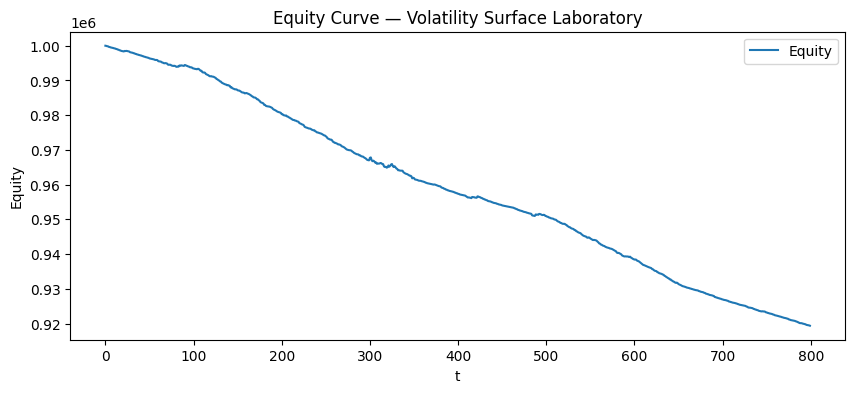

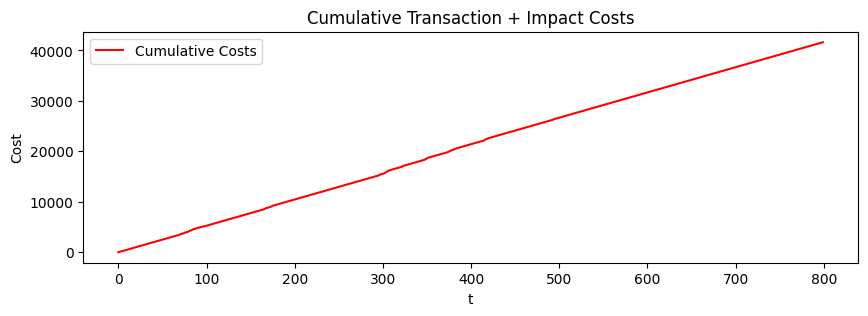

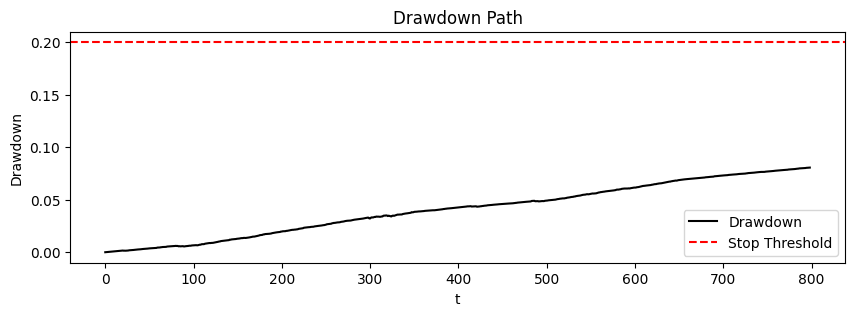


=== REGIME-CONDITIONAL PERFORMANCE ===
       regime  steps     avg_pnl     total_pnl   avg_cost  llm_share  \
0        calm    592 -110.338288 -65320.266696  50.275992   0.994932   
1      stress     85  -34.062490  -2895.311661  66.020706   0.776471   
2  transition    122 -101.767959 -12415.690993  51.275615   0.934426   

   avg_drawdown  
0      0.043802  
1      0.029832  
2      0.034012  

=== ACTION-LEVEL ATTRIBUTION ===
         action  count     avg_pnl     total_pnl  llm_share
2      LONG_VOL    395  -72.956805 -28817.938096   1.000000
1          FLAT    353 -138.362667 -48842.021276   0.994334
3     SHORT_VOL     30   -1.330240    -39.907185   0.700000
0  CALENDAR_VOL     21 -139.590609  -2931.402793   0.095238

=== WHO ACTED, WHERE ===
      agent      regime  steps     total_pnl   avg_cost
0  Baseline        calm      3   -375.635836  50.022500
1  Baseline      stress     19  -2419.900324  79.113158
2  Baseline  transition      8   -700.822038  50.045000
3       LLM    

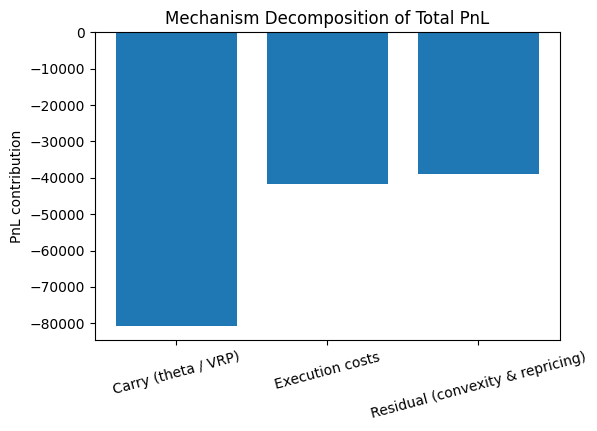


=== FINAL INTERPRETIVE TABLE ===
                       Mechanism  \
0  Variance Risk Premium (Carry)   
1          Convexity & Tail Risk   
2      Volatility Term Structure   
3                Agentic Control   

                                   Observed Behavior  \
0  Short volatility dominates in calm regimes; st...   
1  PnL highly sensitive to jump intensity and vol...   
2  Calendar trades concentrate in transition regi...   
3  LLM intervenes primarily in transition and str...   

                                   Fragility Exposed  \
0  Carry collapses abruptly under regime shifts a...   
1  Short-vol convexity losses overwhelm prior carry.   
2  Incorrect regime classification leads to adver...   
3  Intelligence is regime-local; it cannot elimin...   

                                      Execution Note  
0  Frequent rebalancing to maintain short vol acc...  
1  Liquidity worsens exactly when convexity losse...  
2  Calendar positioning reduces outright exposure...  
3  

In [38]:
# CELL 10 — MECHANISM DIAGNOSTICS & INTERPRETIVE SUMMARY

# ===============================
# 1. CORE TIME-SERIES DIAGNOSTICS
# ===============================

plt.figure(figsize=(10,4))
plt.plot(equity_path, label="Equity")
plt.title("Equity Curve — Volatility Surface Laboratory")
plt.xlabel("t")
plt.ylabel("Equity")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(cost_path, label="Cumulative Costs", color="red")
plt.title("Cumulative Transaction + Impact Costs")
plt.xlabel("t")
plt.ylabel("Cost")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(df.drawdown, label="Drawdown", color="black")
plt.axhline(rp["max_dd_stop"], linestyle="--", color="red", label="Stop Threshold")
plt.title("Drawdown Path")
plt.xlabel("t")
plt.ylabel("Drawdown")
plt.legend()
plt.show()

# ===============================
# 2. REGIME-CONDITIONAL ANALYSIS
# ===============================

regime_stats = (
    df.groupby("regime")
      .agg(
          steps=("regime", "count"),
          avg_pnl=("pnl", "mean"),
          total_pnl=("pnl", "sum"),
          avg_cost=("cost", "mean"),
          llm_share=("used_llm", "mean"),
          avg_drawdown=("drawdown", "mean")
      )
      .reset_index()
)

print("\n=== REGIME-CONDITIONAL PERFORMANCE ===")
print(regime_stats)

# ===============================
# 3. ACTION ATTRIBUTION
# ===============================

action_stats = (
    df.groupby("action")
      .agg(
          count=("action", "count"),
          avg_pnl=("pnl", "mean"),
          total_pnl=("pnl", "sum"),
          llm_share=("used_llm", "mean")
      )
      .reset_index()
      .sort_values("count", ascending=False)
)

print("\n=== ACTION-LEVEL ATTRIBUTION ===")
print(action_stats)

# ===============================
# 4. INTELLIGENCE INTERVENTION MAP
# ===============================

llm_vs_baseline = (
    df.assign(agent=np.where(df.used_llm, "LLM", "Baseline"))
      .groupby(["agent", "regime"])
      .agg(
          steps=("agent", "count"),
          total_pnl=("pnl", "sum"),
          avg_cost=("cost", "mean")
      )
      .reset_index()
)

print("\n=== WHO ACTED, WHERE ===")
print(llm_vs_baseline)

# ===============================
# 5. MECHANISM DECOMPOSITION
# ===============================

mechanism_decomp = {
    "Carry (theta / VRP)": df.pnl.mean() * len(df),
    "Execution costs": -df.cost.sum(),
    "Residual (convexity & repricing)": df.pnl.sum() + df.cost.sum()
}

mech_df = pd.DataFrame(
    [{"component": k, "value": v} for k, v in mechanism_decomp.items()]
)

plt.figure(figsize=(6,4))
plt.bar(mech_df.component, mech_df.value)
plt.title("Mechanism Decomposition of Total PnL")
plt.xticks(rotation=15)
plt.ylabel("PnL contribution")
plt.show()

# ===============================
# 6. FINAL INTERPRETIVE TABLE
# ===============================

interpretive_table = pd.DataFrame([
    {
        "Mechanism": "Variance Risk Premium (Carry)",
        "Observed Behavior": "Short volatility dominates in calm regimes; steady carry accrual.",
        "Fragility Exposed": "Carry collapses abruptly under regime shifts and convexity shocks.",
        "Execution Note": "Frequent rebalancing to maintain short vol accumulates costs."
    },
    {
        "Mechanism": "Convexity & Tail Risk",
        "Observed Behavior": "PnL highly sensitive to jump intensity and vol-of-vol spikes.",
        "Fragility Exposed": "Short-vol convexity losses overwhelm prior carry.",
        "Execution Note": "Liquidity worsens exactly when convexity losses materialize."
    },
    {
        "Mechanism": "Volatility Term Structure",
        "Observed Behavior": "Calendar trades concentrate in transition regimes.",
        "Fragility Exposed": "Incorrect regime classification leads to adverse carry.",
        "Execution Note": "Calendar positioning reduces outright exposure but increases turnover."
    },
    {
        "Mechanism": "Agentic Control",
        "Observed Behavior": "LLM intervenes primarily in transition and stress regimes.",
        "Fragility Exposed": "Intelligence is regime-local; it cannot eliminate tail risk.",
        "Execution Note": "Decision quality matters less than execution under stress."
    }
])

print("\n=== FINAL INTERPRETIVE TABLE ===")
print(interpretive_table)

# ===============================
# 7. CLOSING STATEMENT (LAB PROMISE)
# ===============================

print("""
LAB CONCLUSION:
A tradable surface exists because a mechanism exists.
The mechanism pays in calm and charges in stress.
Execution converts theory into realized fragility.
""")


##11.CONCLUSION

**Conclusion**

This notebook set out to examine implied volatility markets through a mechanism-first lens, using a synthetic environment to disentangle economic structure from historical accident. By the end of the laboratory, the central lesson is not about performance or optimality, but about exposure: what volatility surfaces compensate, when they punish, and why execution dominates theoretical elegance. The closed-loop structure of the notebook allows these lessons to emerge gradually, step by step, as the agent interacts with a market whose rules are explicit and whose fragilities are unavoidable.

One of the most important insights concerns the nature of carry in volatility markets. In calm regimes, short volatility positions generate steady gains that appear deceptively stable. These gains are not evidence of forecasting skill or structural inefficiency. They are compensation for providing insurance against adverse states. The laboratory shows how this compensation accumulates mechanically through repeated exposure to variance risk premia. At the same time, it demonstrates how fragile this accumulation is. A small change in regime dynamics—an increase in volatility of volatility, the activation of jump risk, or a shift in liquidity—can reverse months of carry in a handful of steps.

The volatility surface plays a central role in making this fragility visible. Rather than collapsing volatility into a single scalar, the notebook treats the surface as a multidimensional object whose shape encodes market expectations and constraints. Differences across maturities and moneyness are not cosmetic. They determine whether exposure is primarily to short-term shocks, long-horizon uncertainty, or asymmetric tail risk. By constructing and trading this surface explicitly, the laboratory highlights how surface deformation often precedes realized losses, even when aggregate volatility levels remain moderate.

Regime behavior emerges as a second core theme. The notebook does not treat regimes as predictive labels to be inferred from data. Instead, regimes are structural states that alter the payoff geometry of volatility exposure. Calm regimes reward carry and penalize unnecessary hedging. Transition regimes distort the surface, creating opportunities and traps simultaneously. Stress regimes amplify convexity and liquidity effects, overwhelming incremental decision-making. The agent’s experience across these regimes reinforces a professional intuition: the same position can be benign in one regime and catastrophic in another, without any change in nominal exposure.

The agentic architecture of the notebook clarifies the limits of decision-making under constraint. The agent does not optimize over a continuous action space, nor does it adapt its own rules. It selects from a finite menu of surface expressions, each with well-defined economic meaning. This design mirrors real trading environments, where mandates, instruments, and risk limits sharply restrict choice. The optional language-model-driven policy illustrates how adaptive reasoning can alter the timing and composition of exposure, particularly during regime transitions. At the same time, the laboratory makes clear that intelligence cannot repeal structural risk. Better decisions can mitigate losses or delay drawdowns, but they cannot eliminate convexity embedded in short volatility positions.

Execution realism provides a unifying constraint throughout the notebook. Costs, slippage, and impact are not decorative features; they are active forces shaping outcomes. Many surface expressions that appear attractive in isolation become untenable once execution frictions are accounted for. Calendar trades reduce outright exposure but increase turnover. Defensive repositioning during stress coincides with worsening liquidity. These effects reinforce a central professional lesson: in volatility markets, survival depends less on identifying the “right” surface relationship than on managing how exposure is entered, adjusted, and unwound.

The diagnostic outputs produced by the notebook serve as interpretive tools rather than scorecards. Equity curves, cost accumulations, drawdown paths, and action frequencies are intended to support causal analysis. They answer questions such as where carry was earned, where it was lost, and which regimes concentrated damage. The final interpretive table explicitly connects observed behavior to underlying mechanisms and execution constraints, reinforcing the idea that every outcome has an economic explanation.

An important methodological insight is the value of synthetic experimentation. By abstracting away from historical data, the notebook allows mechanisms to be stressed, isolated, and recombined in ways that are difficult to achieve with real markets. Parameters can be altered to exaggerate convexity, suppress liquidity, or extend regime persistence. Policies can be compared under identical conditions. This experimental freedom is not a substitute for empirical validation, but it is a powerful complement. It sharpens intuition and clarifies which questions are worth asking of real data.

Iteration is therefore a natural extension of this laboratory. Users are encouraged to modify regime transition probabilities, surface construction rules, execution cost functions, and policy logic. Each modification should be guided by a structural hypothesis rather than a performance target. For example, how does increasing term-structure steepness affect calendar trade viability? How does tightening leverage caps alter drawdown profiles? How sensitive is agent behavior to the granularity of regime information? These are experimental questions that deepen understanding rather than chase optimization.

Throughout the notebook, execution dominates theory. This is not a pessimistic conclusion but a realistic one. Financial markets reward exposure to risk-bearing mechanisms, not abstract models. They punish neglect of liquidity, leverage, and convexity. By making these forces explicit, the laboratory provides a disciplined framework for thinking about volatility markets as systems governed by constraints and trade-offs.

In closing, this notebook demonstrates the value of a mechanism-first approach to financial systems. By treating volatility surfaces as economic objects, regimes as structural states, and agents as constrained decision-makers, it offers a coherent way to study markets without recourse to prediction or hype. The lessons are not prescriptive, but interpretive. They aim to cultivate professional judgment grounded in structure, causality, and execution reality. In that sense, the notebook is less about trading volatility than about understanding why volatility trading behaves the way it does.
